In [1]:
%matplotlib inline
import numpy as np

---

**作者**：Gaël Varoquaux

---

这篇教程探索了更好的理解代码基础、寻找并修复bug的工具。

这部分内容并不是特别针对于科学Python社区，但是我们将要采用的策略是专门针对科学计算量身定制的。

---
**先决条件**

- Numpy
- IPython
- nosetests (http://readthedocs.org/docs/nose/en/latest/)
- pyflakes (http://pypi.python.org/pypi/pyflakes)
- gdb对C-debugging部分。

---


---
**章节内容**
- 避免bugs
    - 避免麻烦的最佳代码实践
    - pyflakes：快速静态分析
        - 在当前编辑的文件上运行pyflakes
        - 随着打字进行的拼写检查器整合
- 查错工作流
- 使用Python除错器
    - 激活除错器
        - 事后剖析
        - 逐步执行
        - 启动除错器的其他方式
    - 除错器命令与交互
        - 在除错器中获得帮助
- 使用gdb排除代码段的错误

---

## 2.3.1 避免bugs

### 2.3.1.1 避免麻烦的最佳代码实践

---
**Brian Kernighan**

“每个人都知道除错比从零开始写一个程序难两倍。因此，如果当你写程序时足够聪明，为什么你不对它进行除错呢？”

---

- 我都会写出有错误的代码。接收这些代码。处理这些代码。
- 写代码时记得测试和除错。
- 保持简单和直接（KISS）。
    - 能起作用的最简单的事是什么？
- 不要重复自身（DRY）。
    - 每一个知识碎片都必须在系统中有一个清晰、权威的表征
    - 变量、算法等等  
- 试着限制代码的依赖。（松耦合）
- 给变量、函数和模块有意义的名字（而不是数学名字）

### 2.3.1.2 pyflakes：快速静态分析

在Python中有一些静态分析；举几个例子：
- [pylint](http://www.logilab.org/857)
- [pychecker](http://pychecker.sourceforge.net/)
- [pyflakes](http://pypi.python.org/pypi/pyflakes)
- [pep8](http://pypi.python.org/pypi/pep8)
- [flake8](http://pypi.python.org/pypi/flake8)

这里我们关注`pyflakes`，它是最简单的工具。
- **快速**、**简单**
- 识别语法错误、没有imports、名字打印打错。

另一个好的推荐是`flake8`工具，是pyflakes和pep8。因此，除了pyflakes捕捉错误类型外，flake8也可以察觉对[PEP8](http://www.python.org/dev/peps/pep-0008/)风格指南建议的违背。

强烈推荐在你的编辑器或IDE整合pyflakes (或 flake8)，**确实可以产出生产力的收益**。

#### 2.3.1.2.1 在当前编辑文件上运行pyflakes

你可以在当前缓存器中绑定一个键来运行pyflakes。
- **在kate中**
    - 菜单：设定 -> 配置 kate
    - 在插件中启用“外部”
    - 在外部工具，添加pyflakes：

In [ ]:
kdialog --title "pyflakes %filename" --msgbox "$(pyflakes %filename)"

- **在TextMate中**
    - 菜单: TextMate -> 偏好 -> 高级 -> Shell变量，添加shell变量:

In [ ]:
TM_PYCHECKER=/Library/Frameworks/Python.framework/Versions/Current/bin/pyflakes

    - 然后 Ctrl-Shift-V 被绑定到pyflakes报告

- **在vim中**
    - 在你的vimrc中 (将F5绑定到pyflakes):

In [ ]:
autocmd FileType python let &mp = 'echo "*** running % ***" ; pyflakes %'
autocmd FileType tex,mp,rst,python imap <Esc>[15~ <C-O>:make!^M
autocmd FileType tex,mp,rst,python map  <Esc>[15~ :make!^M
autocmd FileType tex,mp,rst,python set autowrite

- **在emacs中**
    - 在你的emacs中 (将F5绑定到pyflakes):

In [ ]:
(defun pyflakes-thisfile () (interactive)
       (compile (format "pyflakes %s" (buffer-file-name)))
)

(define-minor-mode pyflakes-mode
    "Toggle pyflakes mode.
    With no argument, this command toggles the mode.
    Non-null prefix argument turns on the mode.
    Null prefix argument turns off the mode."
    ;; The initial value.
    nil
    ;; The indicator for the mode line.
    " Pyflakes"
    ;; The minor mode bindings.
    '( ([f5] . pyflakes-thisfile) )
)

(add-hook 'python-mode-hook (lambda () (pyflakes-mode t)))

####2.3.1.2.2 随着打字进行的拼写检查器整合

- **在vim中**
    - 使用pyflakes.vim插件:
        1. 从http://www.vim.org/scripts/script.php?script_id=2441 下载zip文件
        2. 将文件提取到~/.vim/ftplugin/python
        3. 确保你的vimrc的filetype插件的缩进是开启的
    ![](http://scipy-lectures.github.io/_images/vim_pyflakes.png)
    - 或者: 使用syntastic插件。这个插件也可以设置为使用flake8，处理实时检查许多其他语言。
    ![](http://scipy-lectures.github.io/_images/vim_syntastic.png)
    
- **在emacs中**
    - 使用flymake模式以及pyflakes, 文档在http://www.plope.com/Members/chrism/flymake-mode : 在你的.emacs文件中添加下来代码:

In [ ]:
(when (load "flymake" t)
        (defun flymake-pyflakes-init ()
        (let* ((temp-file (flymake-init-create-temp-buffer-copy
                            'flymake-create-temp-inplace))
            (local-file (file-relative-name
                        temp-file
                        (file-name-directory buffer-file-name))))
            (list "pyflakes" (list local-file))))

        (add-to-list 'flymake-allowed-file-name-masks
                '("\\.py\\'" flymake-pyflakes-init)))

(add-hook 'find-file-hook 'flymake-find-file-hook)

## 2.3.2 除错工作流

如果你确实有一个非无关紧要的bug，这个时候就是除错策略该介入的时候。没有银子弹。但是，策略会有帮助：
    
    对于给定问题的除错，最合适的情况是当问题被隔离在几行代码的时候，外面是框架或应用代码，有较短的修改-运行-失败循环。

1. 让它可以可靠的失败。找到一个测试案例，可以让代码每次都失败。
2. 分而治之。一旦你有一个测试案例，隔离错误的代码。
    - 哪个模块。
    - 哪个函数。
    - 哪行代码。
    
    =>隔离小的可重复错误：测试案例
3. 每次只改变一个事情并且重新运行失败的测试案例。
4. 使用除错器来理解哪里出错了。
5. 耐心的记笔记。可能会花一些时间。

    **笔记**：一旦你遵从了这个流程：隔离一段可以重现bug的紧密代码段，并且用这段代码来修复bug，添加对应代码到你的测试套装。

## 2.3.3 使用Python除错器

python除错器，pdb: http://docs.python.org/library/pdb.html, 允许你交互的检查代码。

具体来说，它允许你：
- 查看源代码。
- 在调用栈上下游走。
- 检查变量值。
- 修改变量值。
- 设置断点。

---
**print**
是的，print语句确实可以作为除错工具。但是，要检查运行时间，使用除错器通常更加高效。

--

### 2.3.3.1 激活除错器

启动除错器的方式:
1. 事后剖析，在模块错误后启动除错器。
2. 用除错器启动模块。
3. 在模块中调用除错器。

#### 2.3.3.1.1 事后剖析

**情景**: 你在IPython中工作时，你的到了一个traceback。

这里我们除错文件[index_error.py](http://scipy-lectures.github.io/_downloads/index_error.py)。当运行它时，抛出`IndexError`。输入`%debug`进入除错器。

In [1]:
%run index_error.py

IndexError: list index out of range

In [2]:
%debug

> /Users/cloga/Documents/scipy-lecture-notes_cn/index_error.py(5)index_error()
      4     lst = list('foobar')
----> 5     print lst[len(lst)]
      6 

ipdb> list
      1 """Small snippet to raise an IndexError."""
      2 
      3 def index_error():
      4     lst = list('foobar')
----> 5     print lst[len(lst)]
      6 
      7 if __name__ == '__main__':
      8     index_error()
      9 

ipdb> len(lst)
6
ipdb> print lst[len(lst)-1]
r
ipdb> quit


---

**不用IPthon的事后剖析除错**

在一些情况下，你不可以使用IPython，例如除错一个想到从命令行调用的脚本。在这个情况下，你可以用`python -m pdb script.py`调用脚本：

```
$ python -m pdb index_error.py
> /home/varoquau/dev/scipy-lecture-notes/advanced/debugging_optimizing/index_error.py(1)<module>()
-> """Small snippet to raise an IndexError."""
(Pdb) continue
Traceback (most recent call last):
File "/usr/lib/python2.6/pdb.py", line 1296, in main
    pdb._runscript(mainpyfile)
File "/usr/lib/python2.6/pdb.py", line 1215, in _runscript
    self.run(statement)
File "/usr/lib/python2.6/bdb.py", line 372, in run
    exec cmd in globals, locals
File "<string>", line 1, in <module>
File "index_error.py", line 8, in <module>
    index_error()
File "index_error.py", line 5, in index_error
    print lst[len(lst)]
IndexError: list index out of range
Uncaught exception. Entering post mortem debugging
Running 'cont' or 'step' will restart the program
> /home/varoquau/dev/scipy-lecture-notes/advanced/debugging_optimizing/index_error.py(5)index_error()
-> print lst[len(lst)]
(Pdb)
```

---

#### 2.3.3.1.2 逐步执行

**情景**：你相信模块中存在bug，但是你不知道在哪。

例如我们想要除错[wiener_filtering.py](http://scipy-lectures.github.io/_downloads/wiener_filtering.py)。代码确实可以运行，但是，过滤不起作用。

- 在IPython用`%run -d wiener_filtering.p`来运行这个脚本：

```
In [1]: %run -d wiener_filtering.py
*** Blank or comment
*** Blank or comment
*** Blank or comment
Breakpoint 1 at /home/varoquau/dev/scipy-lecture-notes/advanced/debugging_optimizing/wiener_filtering.py:4
NOTE: Enter 'c' at the ipdb>  prompt to start your script.
> <string>(1)<module>()
```

- 用`b 34`在34行设置一个断点:

```
ipdb> n
> /home/varoquau/dev/scipy-lecture-notes/advanced/debugging_optimizing/wiener_filtering.py(4)<module>()
      3
1---> 4 import numpy as np
      5 import scipy as sp

ipdb> b 34
Breakpoint 2 at /home/varoquau/dev/scipy-lecture-notes/advanced/debugging_optimizing/wiener_filtering.py:34
```

- 用`c(ont(inue))`继续运行到下一个断点:

```
ipdb> c
> /home/varoquau/dev/scipy-lecture-notes/advanced/debugging_optimizing/wiener_filtering.py(34)iterated_wiener()
     33     """
2--> 34     noisy_img = noisy_img
     35     denoised_img = local_mean(noisy_img, size=size)
```

- 用`n(ext)`和`s(tep)`在代码中步进：`next`在当前运行的背景下跳跃到下一个语句，而`step`将跨过执行的背景，即可以检查内部函数调用：

```
ipdb> s
> /home/varoquau/dev/scipy-lecture-notes/advanced/debugging_optimizing/wiener_filtering.py(35)iterated_wiener()
2    34     noisy_img = noisy_img
---> 35     denoised_img = local_mean(noisy_img, size=size)
     36     l_var = local_var(noisy_img, size=size)

ipdb> n
> /home/varoquau/dev/scipy-lecture-notes/advanced/debugging_optimizing/wiener_filtering.py(36)iterated_wiener()
     35     denoised_img = local_mean(noisy_img, size=size)
---> 36     l_var = local_var(noisy_img, size=size)
     37     for i in range(3):
```

- 跨过一些行，并且检查本地变量：

```
ipdb> n
> /home/varoquau/dev/scipy-lecture-notes/advanced/debugging_optimizing/wiener_filtering.py(37)iterated_wiener()
     36     l_var = local_var(noisy_img, size=size)
---> 37     for i in range(3):
     38         res = noisy_img - denoised_img
ipdb> print l_var
[[5868 5379 5316 ..., 5071 4799 5149]
 [5013  363  437 ...,  346  262 4355]
 [5379  410  344 ...,  392  604 3377]
 ...,
 [ 435  362  308 ...,  275  198 1632]
 [ 548  392  290 ...,  248  263 1653]
 [ 466  789  736 ..., 1835 1725 1940]]
ipdb> print l_var.min()
0
```

哦，天啊，只有整合和0的变体。这就是我们的Bug，我们正在做整数算术。

---

**在数字错误上抛出异常**

当我们运行`wiener_filtering.py`文件时，将抛出下列警告：

wiener_filtering.py:40: RuntimeWarning: divide by zero encountered in divide
  noise_level = (1 - noise/l_var )


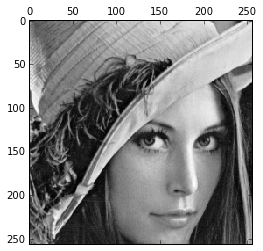

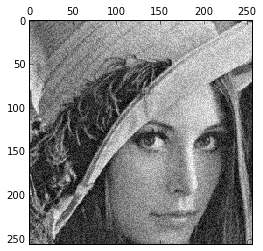

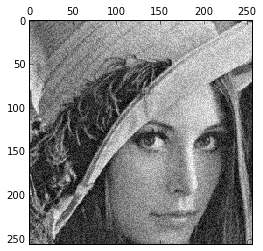

In [3]:
%run wiener_filtering.py

我们可以将这些警告变成异常，这使我们可以做事后剖析对他们进行查错，更快的找到我们的问题：

In [5]:
np.seterr(all='raise')

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

In [6]:
%run wiener_filtering.py

FloatingPointError: divide by zero encountered in divide

#### 2.3.3.1.3 启动除错器的其他的方式

- 人为设置断点抛出异常
    
    如果你发现记录行数设置断点很枯燥，那么你也可以直接在你想要检查的位置抛出异常然后使用IPython的`%debug`。注意这种情况下，你无法步进或继续这个异常。

- 用nosetests除错测试失败
    
    你可以运行`nosetests --pdb`来进入异常除错的事后剖析，运行`nosetests --pdb-failure`来用除错器检查失败的测试。
    
    此外，你可以通过安装nose插件[ipdbplugin](http://pypi.python.org/pypi/ipdbplugin)来在nose中为除错器使用Ipython界面。然后为nosetest传递`--ipdb`和`--ipdb-failure`选项。

- 显性的调用除错器

    在你想要进入除错器的地方插入下列几行：

In [ ]:
import pdb; pdb.set_trace()

---

**警告**：当运行nosetests时, 会抓取输出，因此会感觉除错器没起作用。只要运行nosetests用-s标记。

---

---

**图形化除错器和其他除错器**

- 对于在代码中步进和检查变量，你会发现用图形化除错器比如[winpdb](http://winpdb.org/)，
- 或者，[pudb](http://pypi.python.org/pypi/pudb)是优秀的半图形除错器，在控制台带有文字用户界面。
- 同时，[pydbgr]项目可能也是值得一看的。

### 2.3.3.2 除错器命令和交互

|   |   |
|---|---|
|l(list)|列出当前位置的代码|
|u(p)|在调用栈上向上走|
|d(own)|在调用栈上向下走|
|n(ext)|执行下一行代码(并不会进入新函数)|
|s(tep)|执行下一个语句(并不会进入新函数)|
|bt|打印调用栈|
|a|打印本地函数|
|!command|执行给到的Python命令(与pdb命令相对)|

---

**警告：除错器命令不是Python代码**

你不能以想要的方式命名变量。例如，如果你无法在当前的框架下用相同的名字覆盖变量：**用不同的名字，然后在除错器中输入代码时使用本地变量**。

####2.3.3.2.1 在除错器中获得帮助

输入`h`或者`help`来进入交互帮助：

In [ ]:
import pdb; pdb.set_trace()

--Call--
> /Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/core/displayhook.py(222)__call__()
-> def __call__(self, result=None):
(Pdb) help

Documented commands (type help <topic>):
EOF    bt         cont      enable  jump  pp       run      unt   
a      c          continue  exit    l     q        s        until 
alias  cl         d         h       list  quit     step     up    
args   clear      debug     help    n     r        tbreak   w     
b      commands   disable   ignore  next  restart  u        whatis
break  condition  down      j       p     return   unalias  where 

Miscellaneous help topics:
exec  pdb

Undocumented commands:
retval  rv



## 2.3.4 用gdb除错段错误（segmentation faults）

如果有段错误，你不可以用pdb对它进行除错，因为在进入除错器之前，它会让Python解释器崩溃。同样的，如果在嵌入Python的C代码中有一个bug，pdb也是没用的。对于这种情况，我们可以转用gnu除错器，[gdb](http://www.gnu.org/s/gdb/)，在Linux可用。

在我们开始使用gdb之前，让我们为它添加一些Python专有的工具。对于这个情况我们可以添加一些宏到我们的`~/.gbdinit`。宏的最优的选择取决于你的Python版本和gdb版本。我在[gdbint](http://scipy-lectures.github.io/_downloads/gdbinit)添加了一个简单的版本，但是别客气读一下[DebuggingWithGdb](http://wiki.python.org/moin/DebuggingWithGdb)。

要用gdb来除错Python脚本[segfault.py](http://scipy-lectures.github.io/_downloads/segfault.py), 我们可以想如下这样在gdb中运行这个脚本

```
$ gdb python
...
(gdb) run segfault.py
Starting program: /usr/bin/python segfault.py
[Thread debugging using libthread_db enabled]

Program received signal SIGSEGV, Segmentation fault.
_strided_byte_copy (dst=0x8537478 "\360\343G", outstrides=4, src=
    0x86c0690 <Address 0x86c0690 out of bounds>, instrides=32, N=3,
    elsize=4)
        at numpy/core/src/multiarray/ctors.c:365
365            _FAST_MOVE(Int32);
(gdb)
```

我们得到了一个segfault, gdb捕捉到它在C级栈（并不是Python调用栈）中进行事后剖析除错。我们可以用gdb的命令来对C调用栈进行除错：

```
(gdb) up
#1  0x004af4f5 in _copy_from_same_shape (dest=<value optimized out>,
    src=<value optimized out>, myfunc=0x496780 <_strided_byte_copy>,
    swap=0)
at numpy/core/src/multiarray/ctors.c:748
748         myfunc(dit->dataptr, dest->strides[maxaxis],
```

如你所见，现在，我们numpy的C代码中。我们想要知道哪个Python代码触发了这个segfault，因此，在栈上向上搜寻，直到我们达到Python执行循环：

```
(gdb) up
#8  0x080ddd23 in call_function (f=
    Frame 0x85371ec, for file /home/varoquau/usr/lib/python2.6/site-packages/numpy/core/arrayprint.py, line 156, in _leading_trailing (a=<numpy.ndarray at remote 0x85371b0>, _nc=<module at remote 0xb7f93a64>), throwflag=0)
    at ../Python/ceval.c:3750
3750    ../Python/ceval.c: No such file or directory.
        in ../Python/ceval.c

(gdb) up
#9  PyEval_EvalFrameEx (f=
    Frame 0x85371ec, for file /home/varoquau/usr/lib/python2.6/site-packages/numpy/core/arrayprint.py, line 156, in _leading_trailing (a=<numpy.ndarray at remote 0x85371b0>, _nc=<module at remote 0xb7f93a64>), throwflag=0)
    at ../Python/ceval.c:2412
2412    in ../Python/ceval.c
(gdb)
```

一旦我们进入了Python执行循环，我们可以使用特殊的Python帮助函数。例如我们可以找到对应的Python代码：

```
(gdb) pyframe
/home/varoquau/usr/lib/python2.6/site-packages/numpy/core/arrayprint.py (158): _leading_trailing
(gdb)
```

这是numpy代码，我们需要向上走直到找到我们写的代码：

```
(gdb) up
...
(gdb) up
#34 0x080dc97a in PyEval_EvalFrameEx (f=
    Frame 0x82f064c, for file segfault.py, line 11, in print_big_array (small_array=<numpy.ndarray at remote 0x853ecf0>, big_array=<numpy.ndarray at remote 0x853ed20>), throwflag=0) at ../Python/ceval.c:1630
1630    ../Python/ceval.c: No such file or directory.
        in ../Python/ceval.c
(gdb) pyframe
segfault.py (12): print_big_array
```

对应代码是：

In [1]:
def make_big_array(small_array):
    big_array = stride_tricks.as_strided(small_array,
                                         shape=(2e6, 2e6), strides=(32, 32))
    return big_array

def print_big_array(small_array):
    big_array = make_big_array(small_array)

这样segfault在打印`big_array[-10:]`时发生。原因非常简单，`big_array`被分配到程序内存以外。

---
**笔记：**对于在`gdbinit`中定义的Python特有命令，读一下这个文件的源代码。

---

---

**总结练习**

下面的脚本是详细而清晰的。它想要回答一个实际的有趣数值计算，但是，它并不起作用...你可以为它除错吗？

Python源代码：[to_debug.py](http://scipy-lectures.github.io/_downloads/to_debug.py)

In [ ]:
"""
A script to compare different root-finding algorithms.

This version of the script is buggy and does not execute. It is your task
to find an fix these bugs.

The output of the script sould look like:

    Benching 1D root-finder optimizers from scipy.optimize:
                brenth:   604678 total function calls
                brentq:   594454 total function calls
                ridder:   778394 total function calls
                bisect:  2148380 total function calls
"""
from itertools import product

import numpy as np
from scipy import optimize

FUNCTIONS = (np.tan,  # Dilating map
             np.tanh, # Contracting map
             lambda x: x**3 + 1e-4*x, # Almost null gradient at the root
             lambda x: x+np.sin(2*x), # Non monotonous function
             lambda x: 1.1*x+np.sin(4*x), # Fonction with several local maxima
            )

OPTIMIZERS = (optimize.brenth, optimize.brentq, optimize.ridder,
              optimize.bisect)


def apply_optimizer(optimizer, func, a, b):
    """ Return the number of function calls given an root-finding optimizer, 
        a function and upper and lower bounds.
    """
    return optimizer(func, a, b, full_output=True)[1].function_calls,


def bench_optimizer(optimizer, param_grid):
    """ Find roots for all the functions, and upper and lower bounds
        given and return the total number of function calls.
    """
    return sum(apply_optimizer(optimizer, func, a, b)
               for func, a, b in param_grid)


def compare_optimizers(optimizers):
    """ Compare all the optimizers given on a grid of a few different
        functions all admitting a signle root in zero and a upper and
        lower bounds.
    """
    random_a = -1.3 + np.random.random(size=100)
    random_b =   .3 + np.random.random(size=100)
    param_grid = product(FUNCTIONS, random_a, random_b)
    print "Benching 1D root-finder optimizers from scipy.optimize:"
    for optimizer in OPTIMIZERS:
        print '% 20s: % 8i total function calls' % (
                    optimizer.__name__, 
                    bench_optimizer(optimizer, param_grid)
                )


if __name__ == '__main__':
    compare_optimizers(OPTIMIZERS)